# Practical: Data Analysis

In this assignment you will experiment with

- exploring the data collected at a home and a weather station around the Eindhoven area,
- building a predictive model for estimating the amount of electricity produced at the home given a weather forecast.

This notebook will guide you through the typical steps that such work would involve. It shows how to build a simple linear model and your task is to improve on it, i.e. train a model that will provide a more accurate prediction than the simple one.

Throughout this notebook you will find cells starting with **TODO: ...** or `# TODO: ...`. Fill in all these TODO cells. You are encouraged to play with the data and extend this notebook with any interesting insights, beyond the TODOs.

#### Goal

Your task is to train a model on the time series data containing:

- measurements of the amount of electricity produced by the solar panels on the roof of a home in the Eindhoven area
- weather measurements around the Eindhoven airport

in order to predict the hourly solar panel output given the weather forecast for a particular hour of a particular day.

#### Jupyter notebooks

For those who are new to jupyter notebooks, a typical notebook contains text cells (like this one) interleaved with code cells (the gray boxes). You can execute a cell by selecting it and pressing Shift+Enter. The expression in the last line in a cell is the output of that cell. Try executing the following cell.

In [1]:
def add(a, b):
    return a + b

add(1,2)

3

You can find out more about jupyter notbooks at:

- https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/
- http://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Notebook%20Basics.ipynb
- http://nbviewer.jupyter.org/github/jupyter/notebook/tree/master/docs/source/examples/Notebook/

There are some text and code cells starting with **Todo** or `# Todo`. Your task is to fill in these cells with your corresponding text or code. At the end you will deliver the filled in notebook.

#### References

The "Python Data Scinence Handbook" provides a good overview of using python for data data analysis and you are encouraged to consult it during this assignment:

- https://jakevdp.github.io/PythonDataScienceHandbook/

The "Introduction to Statistical Learning" [ISLR] book provides a good introduction to machine learning from the statistical perspective:

- http://www-bcf.usc.edu/~gareth/ISL/

Let's get started!

### Import the relevant libraries

In this assignment we will be using mainly the following libraries:

- `pandas` for organizing the data
- `numpy` for operating on the data
- `matplotlib` for visualizing the data
- `sklearn` for training and evaluating a model on the data
- other utility libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
import sklearn.neural_network as nn
import glob

### Read the data

The data resides in two files:

In [2]:
raw_energy = pd.read_csv("energy_train.csv")
raw_energy.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,time,seconds,total_consumption,total_production,solar_production,total_solar_production
0,2017-01-01,01:00:01,1483228801,13188.301,4499.785,0,4147.1
1,2017-01-01,01:00:11,1483228811,13188.302,4499.785,0,4147.1
2,2017-01-01,01:00:21,1483228821,13188.304,4499.785,0,4147.1
3,2017-01-01,01:00:31,1483228831,13188.305,4499.785,0,4147.1
4,2017-01-01,01:00:41,1483228841,13188.307,4499.785,0,4147.1


In [3]:
raw_weather = pd.read_csv("weather_train.csv")
raw_weather.head()

,time,sun,temperature,chill,humidity,wind direction,wind speed,visibility,air pressure
0,2017-01-01T00:00:00Z,0.0,-1.7,-5.6,99.0,ZZW,3.0,197.0,1026.0
1,2017-01-01T00:10:00Z,0.0,-1.7,-5.6,99.0,ZZW,3.0,195.0,1025.8
2,2017-01-01T00:20:00Z,0.0,-1.7,-5.6,99.0,ZZW,3.0,271.0,1025.6
3,2017-01-01T00:30:00Z,0.0,-1.6,-5.4,99.0,Z,3.0,316.0,1025.4
4,2017-01-01T00:40:00Z,0.0,-1.6,-5.4,99.0,Z,3.0,334.0,1025.3


When analysing data it is important to understand its semantics. In IoT one needs to be extra careful, especially when integrating data from various sources. The very basic information are the units of the measurements, but also the specifications of the sensors gathering the data and the processes that are being monitored. For example, in this case the specification of the solar panel instalation states that it can generate max 42 Jouls per minute.  

Assume the following for the energy data:
- `seconds` is the time the sample was recorded (UTC)
- `total_consumption` is the total amount of electricity that was pulled from the grid (kWh)
- `total_production` is the total amount of electricity that was pushed into the grid (kWh)
- `solar_production` is the amount of eletricity that was produced since the last sample (Wh).
- `total_solar_production` is the total amount of electricity produced by the solar panels (kWh)

Assume the following for the weather data:
- `time` is the time the sample was recorded (UTC)
- `sun` measures whether it was cloudy or sunny at the time when the sample was taken, ranging from 0-3, 0 meaning cloudy and 3 meaning sunny.
- `temperature` is the still temperature (C)
- `chill` is the temperature with the wind chill effect taken into account (C)
- ...

### Explore the data

Exploration is usually the first step in any data analysis task. Visualization is an important tool for exploring the data. It gives insights into the structure and semantics of the data and indications for how to clean it.

The `matplotlib` library provides a collection of useful plots, such as a line plot, scatter plot, histogram, scatter mattrix, etc. You can find out more about this library at 

- https://matplotlib.org/users/pyplot_tutorial.html
- https://matplotlib.org/devdocs/gallery/

The `pandas` library also contains convenient wrappers around the `matplotlib` library for visualizing data frames and series:

- https://pandas.pydata.org/pandas-docs/stable/visualization.html

Let's draw a simple plot of the energy data:

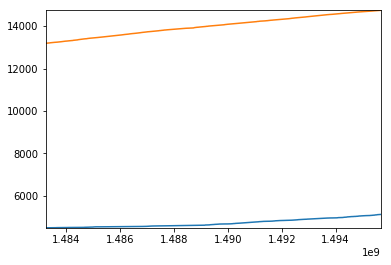

In [4]:
X = raw_energy["seconds"]
Y = raw_energy["total_production"]
Y2 = raw_energy["total_consumption"]
plt.plot(X, Y)
plt.plot(X, Y2)
plt.axis([X.min(), X.max(), Y.min(), Y2.max()])

plt.show()

In [ ]:
# TODO: experiment with other data visualizations

### Clean the data

Data cleaning is an important part of any data analysis task. According to the general wisdom, most effort actually is spent on data cleaning. It involves preparing the data for the following steps, e.g. filling in missing values, removing outliers, normalizing the data, etc.

In the plot above you will have noticed vertical lines. These lines correspond to 0 values and are likely to be measuring errors (e.g. the solar panel meter has crashed). Such outliers will often negatively impact the accuracy of the predictive model and should be removed.

Pandas provides convenient methods for selecting subsets of the data that can be used for removing outliers:

- https://jakevdp.github.io/PythonDataScienceHandbook/03.02-data-indexing-and-selection.html


In [5]:
raw_energy = raw_energy.loc[raw_energy.total_solar_production > 0]

### Engineer features

The goal of this assignment is to predict the hourly energy output of the solar panels given the weather forecast. This requires to relate the energy samples with the weather samples, basically attaching the energy production label to the weather measurements. However, the *total* energy and weather samples are taken approximately every 10 seconds and 10 minutes, respectively.

####  Aggregate per hour

We can use pandas grouping functions to aggregate the samples per hour, taking the largest  measurement in that hour.

In [77]:
col = "total_solar_production"
energy = raw_energy
times = pd.to_datetime(energy["seconds"], unit='s')

energy = energy.groupby([times.dt.year, times.dt.month, times.dt.dayofyear, times.dt.hour])[[col]].agg(np.max)
energy.index.names = ["year", "month", "day", "hour"]

**Todo:** Note that the hourly aggregation using the maximum works well for columns containing the totals. Does it also work the `solar_production` column? Motivate your answer.

For solar_production we should take the average instead of the maximum

After aggregation, some cells can contain `Nan` values (e.g. when trying to compute a maximum for an hour during which no samples were recorded). Therefore, after performing such operations one should decide what to do with any Nans. In this case we chose to remove such samples.

In [78]:
energy = energy.dropna()

After grouping, merging and slicing operations, the index of a data frame might need to be recomputed, to reflect the new ordering of rows.

In [79]:
energy = energy.reset_index()

#### Compute the hourly production

We are interested in predicting the solar panel output in a given hour. However, the energy data frame so far have contains only the total solar panel output until the end of that hour. Assuming that the data set contains a sample for every hour, i.e. there are no gaps, the hourly output can be compouted by taking the difference bebween the previous sample.

In [80]:
energy["production"] = energy[col] - energy[col].shift(1)
energy = energy.dropna().reset_index()

**TODO:** after creating the `production` column the Nans are droppend and the index is recomputed. Why?

Because the beginning has a nan (because of the shift 1) and that nan needs to be removed (and after that we need to reindex)

Now we can perform a similar aggregation for the `sun` column in the weather data. Note that rather than chosing the maximum, we take the average `sun` value per hour.

In [147]:
weather = raw_weather
times = pd.to_datetime(weather["time"])
weather = weather.groupby([times.dt.year, times.dt.month, times.dt.dayofyear, times.dt.hour])["sun", "temperature", "wind speed", "air pressure"].agg(np.mean)
weather.index.names = ["year", "month", "day", "hour"]
weather = weather.reset_index()

weather.head()

,year,month,day,hour,sun,temperature,wind speed,air pressure
0,2017,1,1,0,0.0,-1.650000,3.000000,1025.550000
1,2017,1,1,1,0.0,-1.416667,3.166667,1024.650000
2,2017,1,1,2,0.0,-1.300000,4.000000,1024.066667
3,2017,1,1,3,0.0,-1.216667,3.333333,1023.166667
4,2017,1,1,4,0.0,-1.216667,3.333333,1022.266667


#### Merge the data frames

Now that both data frames are expressed in terms of hours and the energy data frame contains the hourly solar panel output, we can use pandas to merge them.

**Important:** when dealing with times in data from various sources one must be very carefull about the semantics of the time, such as the time-zone or the daylight-saving. Luckily, in this assignment both energy and weather data use UTC time, so no extra preprocessing is required.

In [148]:
data = pd.merge(energy, weather).dropna().reset_index(drop=True)

#### Explore the engineered features

After engineering features it is a good idea to explore the data set again, to see if extra cleaning is required.

0.0 2.5


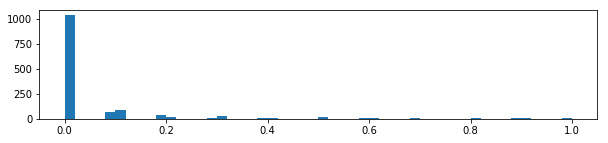

In [51]:
values = data["production"].values
plt.figure(figsize=(10, 2))
plt.hist(values, 50, range=(0,1));
print (min(values), max(values))

The small variance of the values and their large range suggests there are some outliers. This can be also visualized in a different way.

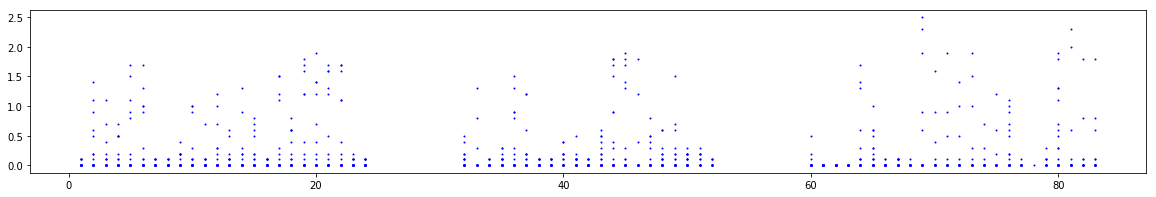

In [52]:
def plot(df, col):
    x = df["day"]
    plt.figure(figsize=(20,3))
    plt.plot(x, df[col], 'bo', markersize=1)

plot(data, "production")

The figure suggests that there are indeed outliers in the energy production data.

**TODO:** How do you explain these outliers?

Note that when removing the energy samples containing 0 values in `raw_energy` earlier, it was clear how to define an outlier. In this case, however, one must carefully decide how to define an outlier, to avoid introducing bias. You can read more about outlier detection here:

- Section 3.3.3 of "Introduction to Statistical Learning"
- http://scikit-learn.org/stable/modules/outlier_detection.html

**TODO**: How you define an outlier for this data set?

A production value that is higher than the specified maximum production

**TODO**: Does your outlier definition introduce bias?

It makes the bias lower, because higher (anomolous) samples are removed.

In [149]:
# remove the outliers
# Fit a gaussian to predict the likelihood of the value of a sample

values = data["production"].values

sigma = np.var(values)
mu = np.mean(values)
print ("Variance: ", sigma, "Mean: ", mu)

#epsilon = 0.01

#filtered_data = data.loc[(1 / (sigma*np.sqrt(2*np.pi))) * np.exp(-0.5 * ((data.production-mu)/sigma)**2) > epsilon]

data_filtered = data.loc[data.production <= 2.55]

new_values = data_filtered["production"].values
print ("New min: ", min(new_values), "New max: ", max(new_values))            

Variance:  6.29387902359 Mean:  0.383236784938
New min:  0.0 New max:  2.5


In [160]:
# Normalize all features
means = data_filtered.mean()
print(means)
maxs = data_filtered.max()
mins = data_filtered.min()

# Normalize and scale the shit out of it
data_norm = (data_filtered - data_filtered.mean()) / (data_filtered.max() - data_filtered.min())

values = data_norm["hour"].values
sigma = np.var(values)
mu = np.mean(values)
print ("Hour variance: ", sigma, "Mean: ", mu)

values = data_norm["sun"].values
sigma = np.var(values)
mu = np.mean(values)
print ("Sun variance: ", sigma, "Mean: ", mu)

values = data_norm["temperature"].values
sigma = np.var(values)
mu = np.mean(values)
print ("Temperature variance: ", sigma, "Mean: ", mu)

values = data_norm["wind speed"].values
sigma = np.var(values)
mu = np.mean(values)
print ("Wind speed variance: ", sigma, "Mean: ", mu)


index                     1380.829694
year                      2017.000000
month                        3.018923
day                         72.723435
hour                        11.525109
total_solar_production    4541.916776
production                   0.275400
sun                          0.953815
temperature                  7.384541
wind speed                   3.410705
air pressure              1019.500790
dtype: float64
Hour variance:  0.089853467906 Mean:  -3.28057167393e-17
Sun variance:  0.151119950602 Mean:  2.55981553276e-16
Temperature variance:  0.0255898489737 Mean:  -1.24112268255e-16
Wind speed variance:  0.0206261071805 Mean:  -3.58115607361e-16


**TODO:** Do you see any outliers or interesting patterns?

### Train a model

For training and evaluating the perfromance of a model we need to split the data into a training and a test.

In [140]:
X = data_norm[["sun", "temperature", "wind speed", "hour"]].as_matrix()
y = data_norm["production"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Evaluate the model

After a model is trained we would like to estimate how well it is performing, whether we can actually trust its predictions if it were deployed. Model performance can be estimated using various visualisations and statistics (see Section 3.1.3 of [ISLR])

#### Model fit

If the feature space is 1 or 2 dimensional, then we can easily plot the model to illustrate how well it fits the test data.

In [17]:
x_plot = np.linspace(min(X), max(X), 100)
X_plot = x_plot.reshape(-1, 1)
y_plot = model.predict(X_plot)

dots, = plt.plot(X_test, y_test, 'bo', markersize=2, color="red", label="training data");
line, = plt.plot(x_plot, y_plot, linewidth=2, label="model");
plt.legend(handles=[dots, line]);

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

We can compute the R2 score to assign a number to how well the model fits the data. It estimates how much of the variance in the data is explained by the model, i.e. how well the model fits the data. A score of 1 means the model captures all of the variance, and a score of 0 means the model does not capture any of the variance.

You can read more about the R2 score in Section 3.1.3 of "Introduction to Statistical Learning".

In [113]:
model.score(X_test, y_test)

0.15622976831878599

#### Residuals

We can also plot a histogram of the residuals (or errors), i.e. the deviations of the values predicted by our model from the ground truth values (from the test set):

In [145]:
y_pred = model.predict(X_test)
plt.title("Distribution of the residuals")
plt.hist(y_test - y_pred, 50);

ValueError: shapes (285,4) and (5,) not aligned: 4 (dim 1) != 5 (dim 0)

Looking at the histogram you will notice that distribution of the residuals is not symmetric.

**TODO:** Is the model biased, i.e. does it tend to under- or overestimate the solar panel output?

If the model is not biased, or if we are not interested in the bias, then we can compute the mean absolute deviation (MAD) to estimate the expected error of a prediction. E.g. in our case a MAD = 0.345 means that we expect on average our predition to be off by 0.345kWh.

In [195]:
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.090681705644246074

### Improve the model

We have shown here a simple linear model mapping the `sun` feature to the `hourly_production` label. However, this model does not perform very well. The problem could be that the model is underfitting or overfitting the data. You can find more about under- and overfitting in Section 2.1.2, 2.1.3, 6.1 of "Introduction to Statistical Learning".

**TODO:** Is the model underfitting or overfitting the training data?
Probably overfitting as sun is the only parameter that it has, and the output does definitely not depend on the amount of cloudiness only

One could try several things to improve the model.

#### Add more features

One way of improving the simple linear model could be to extend it with more features. You can gain insight into which features could be relevant by plotting the relationship between the features and the labels.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb48ba0a20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fdb48c7ca20>]], dtype=object)

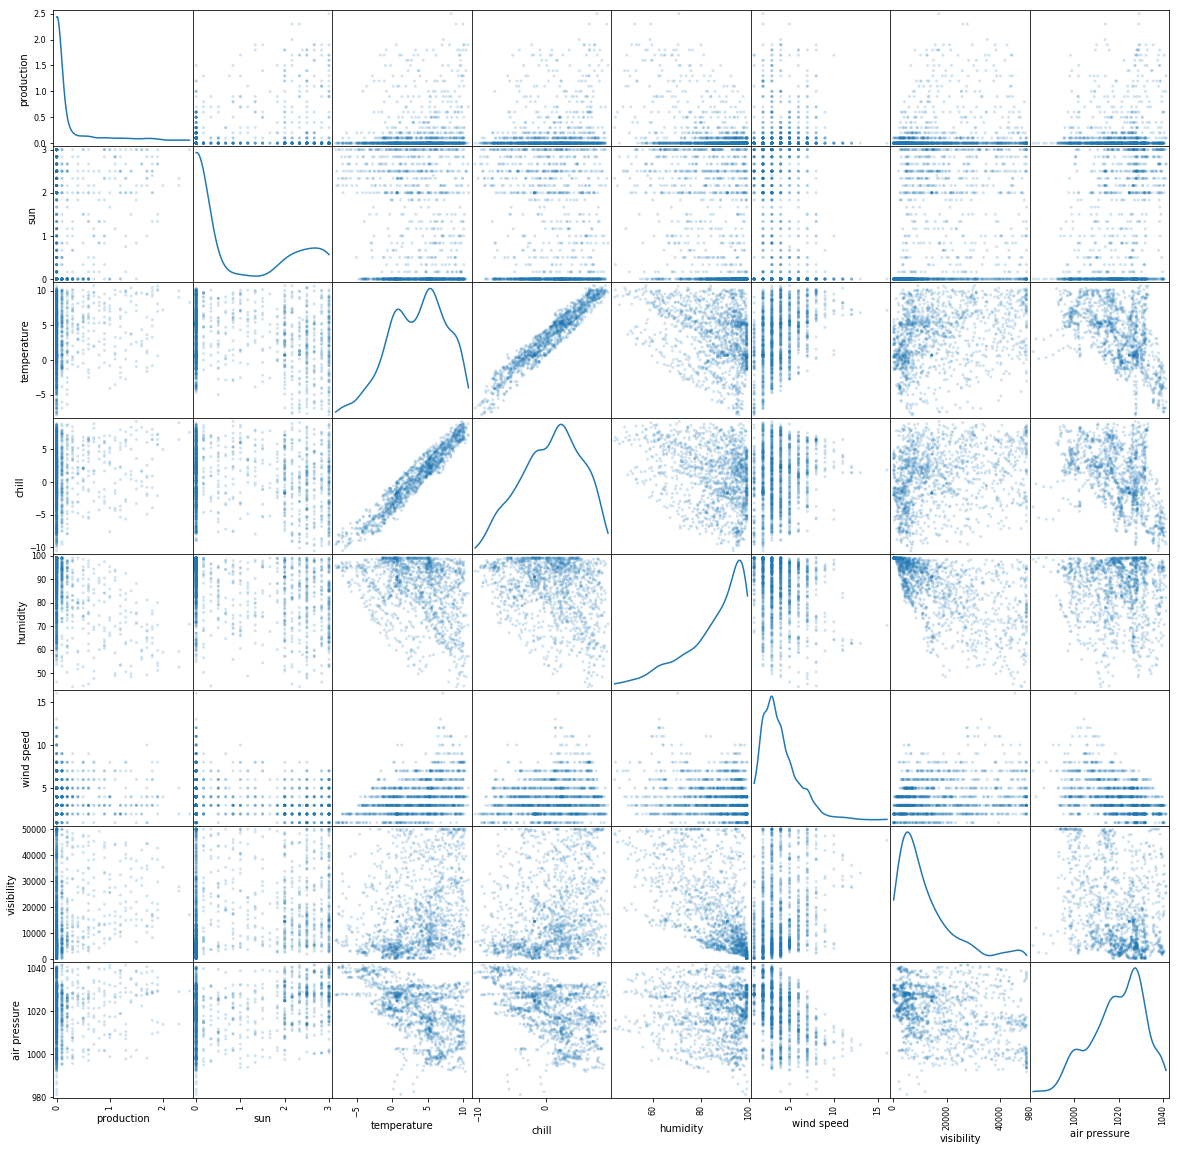

In [196]:
# use the scatter matrix graph to explore the relationship between the features
weather = raw_weather
times = pd.to_datetime(weather["time"])
weather = weather.groupby([times.dt.year, times.dt.month, times.dt.dayofyear, times.dt.hour])

weather1 = weather["sun","temperature","chill","humidity"].agg(np.mean)
weather1.index.names = ["year", "month", "day", "hour"]
weather2 = weather["wind speed","visibility","air pressure"].agg(np.max)
weather2.index.names = ["year", "month", "day", "hour"]
weather = weather1.join(weather2)


weather = weather.reset_index()
graph = pd.merge(energy, weather).dropna().reset_index(drop=True)
graph = graph[['production','sun','temperature','chill','humidity','wind speed','visibility','air pressure']]
# data
# remove the outliers
values_origin = graph["production"].values
values = values_origin
sigma = np.var(values)
mu = np.mean(values)
epsilon = 0.01

filtered_data = graph.loc[(1 / (sigma*np.sqrt(2*np.pi))) * np.exp(-0.5 * ((graph.production-mu)/sigma)**2) > epsilon]

graph = filtered_data
# # pd.scatter_matrix()
pd.tools.plotting.scatter_matrix(graph, alpha=0.2, figsize=(20, 20), diagonal='kde')

**TODO:** Which features are promising for predicting the solar panel output?

**TODO:** Are there other features in the `raw_weather` data that can be used for predicting the solar panel output?

Note that using additional features may require aggregating them per hour. The `sun` feature was aggregated taking the maximum value within a given hour, but this may not be suitable for all features.

In [ ]:
# train a model and evaluate it to estimate the impact of the added features on the performance of the model


#### Choose a more or less flexible model

Another way is to add flexibility to the model e.g. by changing it to a polynomial model or a neural network. You can read more about simple extensions of the linear model in Section 3.3.2 and 6.2 of "Introduction to Statistical Learning".

In [200]:
# explore other models for predicting the solar panel output.
new_model = nn.MLPRegressor(alpha=0.01, hidden_layer_sizes=(100,100,100))
new_model.fit(X_train, y_train)

print("R2 score: {}".format(new_model.score(X_test, y_test)))

y_pred = new_model.predict(X_test)
print("Error: {}".format(mean_absolute_error(y_test, y_pred)))


R2 score: 0.7938155581653875
Error: 0.043518264114002975


**TODO:** Select the model you find best. Why did you chose this model?

Neural nets are super awesome and by definition suited for every possible task. Really? Probably not.
But the good thing about a neural network is that it can capture nonlinearities in the data, which just a linear regression cannot do.

### Simulate the forecasting

The `weather_test.csv` file contains the weather data that was held out from `weather_train.csv` used for training the solar panel output predictor. This data simulates the weather forcasts and is used for evaluating how your model would perform if it was deployed.

Provide the predictions for the hourly solar panel output for the given weather forecasts, i.e. populate the `production` column in the following data frame:

In [198]:
prediction = pd.read_csv('weather_test.csv')
times = pd.to_datetime(prediction["time"])
prediction['month'] = times.dt.month
prediction['day'] = times.dt.dayofyear
prediction['hour'] = times.dt.hour
prediction = prediction.drop(prediction[prediction['hour'] == 0].index)

# Add the required features
prediction = prediction[['month', 'day', 'hour', 'sun', 'temperature', 'wind speed']]
prediction = prediction.drop_duplicates().dropna().reset_index(drop=True)

# Normalize the data
for column in ['hour', 'sun', 'temperature', 'wind speed']:
    data_norm[column] = (prediction[column] - means[column]) / (maxs[column] - mins[column])

X = data_norm[["sun", "temperature", "wind speed", "hour"]].as_matrix()
# Run the model
y = new_model.predict(X)
# Denormalize the result
y = y * (maxs['production'] - mins['production']) + means['production']

prediction['production'] = y

print(prediction)

      month  day  hour  sun  temperature  wind speed  production
0         1   25     1  0.0         -0.4         2.0    0.136293
1         1   25     1  0.0         -0.5         1.0    0.138906
2         1   25     1  0.0         -0.6         2.0    0.137086
3         1   25     1  0.0         -0.7         1.0    0.139786
4         1   25     1  0.0         -0.8         1.0    0.140188
5         1   25     2  0.0         -0.8         1.0    0.140492
6         1   25     2  0.0         -0.8         0.0    0.141499
7         1   25     2  0.0         -0.9         0.0    0.141857
8         1   25     3  0.0         -0.9         0.0    0.142838
9         1   25     3  0.0         -1.0         0.0    0.143176
10        1   25     3  0.0         -0.8         1.0    0.139156
11        1   25     3  0.0         -0.7         1.0    0.138832
12        1   25     3  0.0         -0.7         2.0    0.131032
13        1   25     3  0.0         -0.6         2.0    0.130702
14        1   25     4  0

**Important:** your model will be evaluated on the held out test set. It is therefore safe to train your *final* model on the entire data set that was provided (rather than the X_train, y_train subsets from the train/test split above), to captures all of the information that is available to you.

In [ ]:
# TODO: fill in the production column in the forecast data frame




For automating the evaluation of your predictions, call the evaluate function that is defined in the `evaluate.py` script:

In [199]:
from evaluate import *
evaluate(prediction)

'This is a stub for the evaluation function.'

As a sanity check, make sure that the `prediction` data frame contains a `production` column and 805 rows.